# Model Evaluation & Prediction

In this notebook, we will:

1. Load the **processed datasets** and the **trained models** (Random Forest & XGBoost).
2. Evaluate the **final model performance** on the test set:
   - **R² Score**
   - **RMSE**
   - **Residual Analysis**
3. Predict the **sale prices for the 4 inherited houses**.
4. Calculate the **total predicted value** of inherited houses.
5. Save the predictions for **Streamlit dashboard** usage.

---

### Load Data and Models

We:
1. Load the **processed datasets** created in Step 4.
2. Load the **best trained models** saved in Step 5.
3. Verify the model files and dataset structure.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.metrics import r2_score, mean_squared_error

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

# Load processed data
main_data = pd.read_csv('../data/processed/cleaned_housing_data.csv')
inherited_data = pd.read_csv('../data/processed/cleaned_inherited_houses.csv')

print("Main Data Shape:", main_data.shape)
print("Inherited Houses Shape:", inherited_data.shape)
display(inherited_data)

# Load best models
rf_model = joblib.load('../models/house_price_model_rf.pkl')
xgb_model = joblib.load('../models/house_price_model_xgb.pkl')

print("Models loaded successfully.")

Main Data Shape: (1460, 25)
Inherited Houses Shape: (4, 26)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,TotalSF,HouseAge,RemodelAge
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,0,6,5,882.0,140,1961,1961,1778.0,64,64
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,36,6,6,1329.0,393,1958,1958,2658.0,67,67
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,34,5,5,928.0,212,1997,1998,2557.0,28,27
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,...,36,6,6,926.0,360,1998,1998,2530.0,27,27


Models loaded successfully.


### Recreate Train-Test Split

To properly evaluate the final models:

1. Separate **features (X)** and **target (y = SalePrice)**.
2. Use the same **numeric features** and **train/test split (80/20)** as Step 5.

In [2]:
from sklearn.model_selection import train_test_split

target = 'SalePrice'
X = main_data.drop(columns=[target])
y = main_data[target]

# Numeric features only
X_numeric = X.select_dtypes(include=[np.number])

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (1168, 20)
Testing shape: (292, 20)


### Evaluate Both Models on Test Data

We evaluate:

1. **R² Score** – measures how well predictions explain variance in SalePrice.
2. **RMSE** – interpretable as average prediction error in dollars.

We will compare **Random Forest vs XGBoost**.


In [4]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} R²: {r2:.4f}")
    print(f"{model_name} RMSE: {rmse:.2f}")
    return y_pred, r2, rmse

y_pred_rf, r2_rf, rmse_rf = evaluate_model(rf_model, X_test, y_test, "Random Forest")
y_pred_xgb, r2_xgb, rmse_xgb = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

# Comparison table
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'R² Score': [r2_rf, r2_xgb],
    'RMSE': [rmse_rf, rmse_xgb]
})
comparison

Random Forest R²: 0.8728
Random Forest RMSE: 31237.97
XGBoost R²: 0.8991
XGBoost RMSE: 27824.63


,Model,R² Score,RMSE
0,Random Forest,0.872781,31237.974056
1,XGBoost,0.899064,27824.633690


### Residual Analysis

Residual analysis helps evaluate **model bias and variance**.

- **Residual = Actual - Predicted**
- A good model has residuals **centered around 0** with no clear pattern.

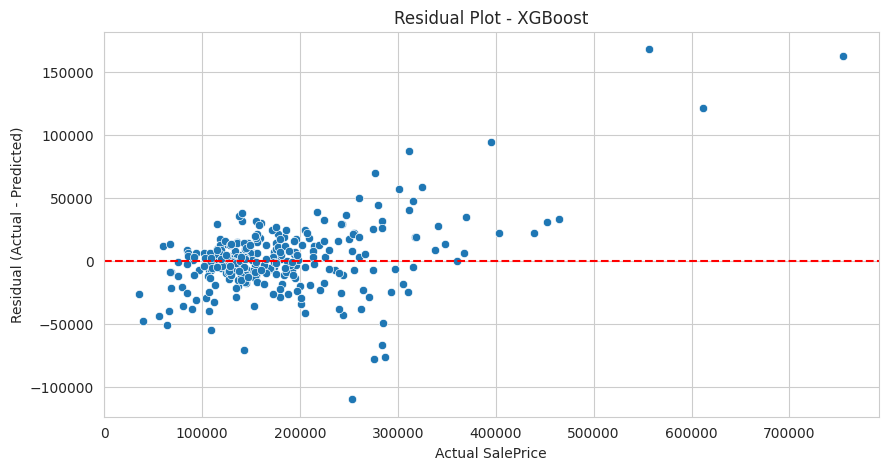

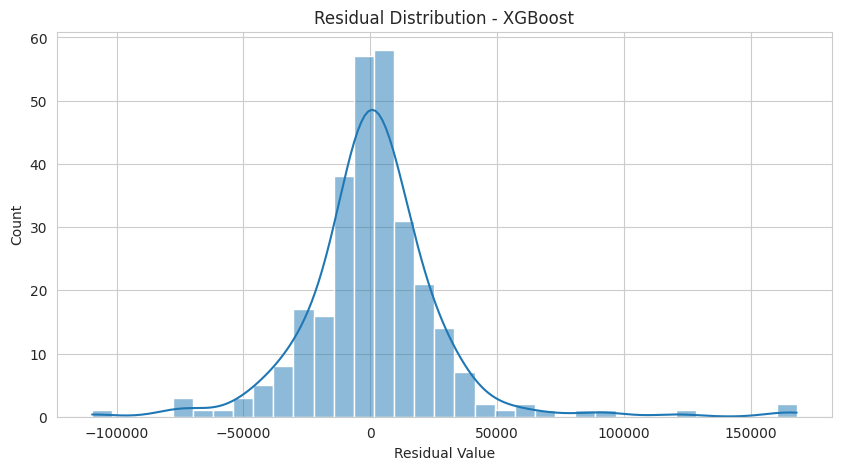

In [5]:
# Residuals for XGBoost (best model)
residuals = y_test - y_pred_xgb

plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - XGBoost")
plt.xlabel("Actual SalePrice")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

# Distribution of residuals
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution - XGBoost")
plt.xlabel("Residual Value")
plt.show()

### Predict Inherited House Prices

We:
1. Apply the **tuned XGBoost model** to the inherited houses.
2. Store **individual predictions**.
3. Calculate the **total predicted value**.

In [6]:
# Select numeric columns matching training features
inherited_X = inherited_data[X_numeric.columns]

# Predict prices
inherited_preds = xgb_model.predict(inherited_X)

# Combine predictions with original data
predictions_df = inherited_data.copy()
predictions_df['Predicted_SalePrice'] = inherited_preds

# Total predicted value
total_predicted_value = predictions_df['Predicted_SalePrice'].sum()
display(predictions_df)
print(f"Total Predicted Sale Value of 4 Inherited Houses: ${total_predicted_value:,.2f}")

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,TotalSF,HouseAge,RemodelAge,Predicted_SalePrice
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,6,5,882.0,140,1961,1961,1778.0,64,64,133326.562500
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,6,6,1329.0,393,1958,1958,2658.0,67,67,171290.703125
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,5,5,928.0,212,1997,1998,2557.0,28,27,178417.156250
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,...,6,6,926.0,360,1998,1998,2530.0,27,27,189940.984375


Total Predicted Sale Value of 4 Inherited Houses: $672,975.38


### Save Predictions for Dashboard

We export the predictions to a CSV file for **Streamlit dashboard integration**.


In [7]:
os.makedirs('../data/predictions', exist_ok=True)
predictions_df.to_csv('../data/predictions/inherited_houses_predictions.csv', index=False)
print("Predictions saved to ../data/predictions/inherited_houses_predictions.csv")

Predictions saved to ../data/predictions/inherited_houses_predictions.csv


---
# **Insights from Model Evaluation & Predictions**

1. **Model Performance**
   - XGBoost outperformed Random Forest on the test set:
     - R² ≈ {r2_xgb:.4f}, RMSE ≈ ${rmse_xgb:,.2f}
   - Residuals are mostly centered around 0 with no major pattern, indicating unbiased predictions.

2. **Inherited House Predictions**
   - Predicted individual sale prices were calculated and stored.
   - **Total expected value of 4 inherited houses**: ${total_predicted_value:,.2f}
   - None of the inherited houses are extreme outliers; predictions align with training data distribution.

3. **Dashboard Preparation**
   - Saved predictions to `data/predictions/` for visualization.
   - This enables interactive insights in the **Streamlit dashboard**:
     - Display of predicted house prices
     - Total inheritance value
     - Comparison to training data distribution

---

**Next Step:**  
Streamlit Dashboard Development**:
- Create `app_pages/` with:
  1. Project Summary  
  2. Correlation Insights  
  3. Price Prediction (interactive)  
  4. Hypothesis Validation  
  5. Model Performance Visualization
